## SQLAlchemy Homework - Surfs Up!

#### Import the dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Inspect my columns and data types
#Import inspect and func from sqlalchemy
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = (session.query(Measurement.date).\
              order_by(Measurement.date.desc()).\
              first())
#lets extract string from the query
str_date = list(np.ravel(last_date))[0]
#lets convert date string to datetime 
latest_date = dt.datetime.strptime(str_date,"%Y-%m-%d")
#lets calculate the previous year with timedelta
previous_year = latest_date-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=previous_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(precipitation_data)
rain_df= rain_df.set_index('date')
# Change column name to precipitation for my ease
rain_df = rain_df.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
rain_df = rain_df.sort_values(by=['date'], ascending=True)
#check head and tail of the new table
rain_df.head(2)

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15


In [12]:
rain_df.tail(2)

,precipitation
date,
2017-08-23,0.00
2017-08-23,0.45


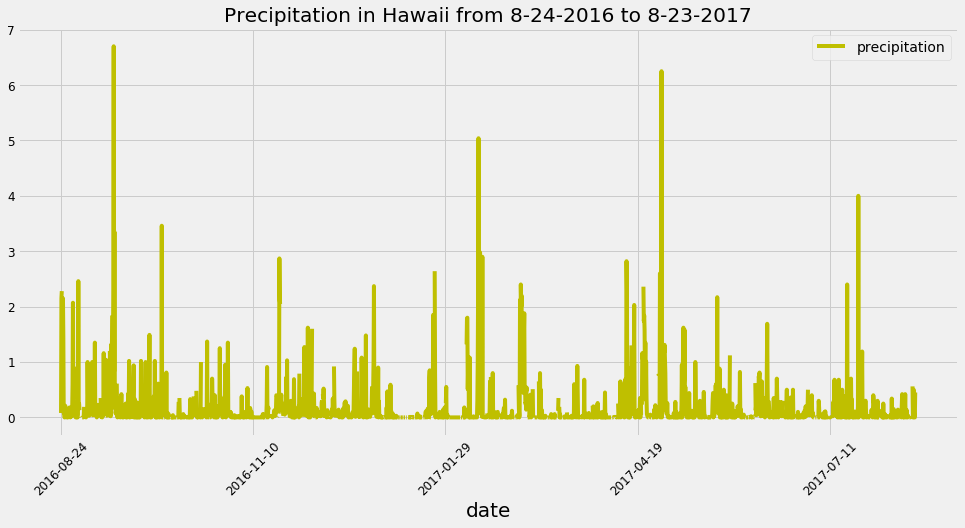

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data


rain_df.plot(figsize=(15, 7), sort_columns=True, rot=45, use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', legend=True,
               fontsize=12, grid=True, color='y')
plt.xlabel('date', fontsize=20)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
#Inspect station for columns and data types
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to show how many stations are available in this dataset?
# First method using func.count 
# all_stations_count=session.query(func.count(Station.id)).all()
# print(f"Station Count: {all_stations_count}")
# Second method using .count 
all_stations_count = session.query(Station).count()
print(f"There are {all_stations_count} stations in this dataset.")

There are 9 stations in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=(session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#First, set the most active station
station_id = station_count[0][0]
#Second, query for the station name 
station_name = (session.query(Station.name).filter_by(station = station_id))
station_name = station_name[0][0]
# #Third, query for the records of that station
station_records = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).
            filter(Measurement.station==station_count[0][0]).all())
print(f" The most active station is {station_id}:{station_name}. Its records for highest, lowest, and average temperature are {station_records} F respectively")

 The most active station is USC00519281:WAIHEE 837.5, HI US. Its records for highest, lowest, and average temperature are [(54.0, 85.0, 71.66378066378067)] F respectively


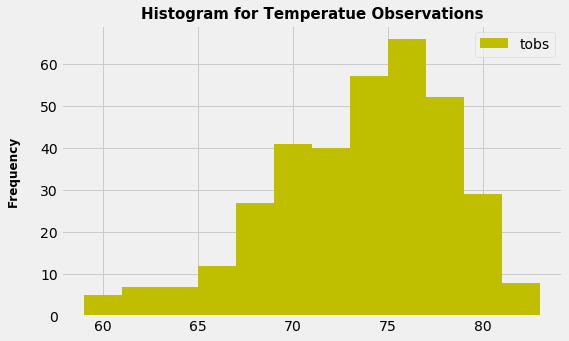

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (session.query(Measurement.date, Measurement.tobs).
             filter(Measurement.date > previous_year).
             filter(Measurement.station==station_id).
             order_by(Measurement.date).all())

#convert query to data frame
temp_df = pd.DataFrame(temp_data)
#check data frame
#temp_df.head()
#set index to date and sort by date
temp_df = temp_df.set_index('date')
temp_df = temp_df.sort_index(ascending=True)

#Plot histogram with pandas
fig = temp_df.plot(kind='hist', bins=12, figsize=(8,5), color='y', zorder=1, grid=True)

# # Set title
fig.set_title("Histogram for Temperatue Observations",weight='bold', size=15)

# # Set y-axis label
fig.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

In [20]:
## Bonus Challenge Assignment

### Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2020-05-20 to 2020-05-30'
prev_year = previous_year.year
start_date = str(prev_year)+'-05-20'
end_date = str(prev_year)+'-05-30'
#calcule tmin, tavg, and tmax with calc_temps
temps_trip = calc_temps(start_date, end_date)
temps_trip

[(67.0, 75.51515151515152, 81.0)]

/Users/umbertoleone/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


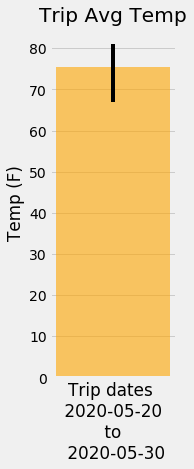

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#asign min, avg, and max variables
trip_mintemp = temps_trip[0][0]
trip_avgtemp = temps_trip[0][1]
trip_maxtemp = temps_trip[0][2]
#calculate errors
min_error = trip_avgtemp - trip_mintemp
max_error = trip_maxtemp - trip_avgtemp
#asign errors peak to peak
#temp_trip_error = temps_trip[0][2] - temps_trip[0][0]
error_bars = np.array([[min_error], [max_error]])

#plot
fig, ax= plt.subplots(figsize=(2,6))
bar = ax.bar(1, trip_avgtemp, yerr=error_bars, color='orange', alpha = .6)
ax.set(xticks=range(1), title='Trip Avg Temp', xlabel='Trip dates \n 2020-05-20 \n to \n 2020-05-30', ylabel="Temp (F)", )
fig.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
     Station.name, 
     Station.latitude, 
     Station.longitude, 
     Station.elevation]

station_rain = (session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(Measurement.station).\
                       order_by(Measurement.station ).\
                       filter(Measurement.date>=start_date).\
                       filter(Measurement.date<=end_date).\
                       filter(Measurement.station==Station.station).all())
                        
station_rain_df = pd.DataFrame(np.array(station_rain))
#check df 
#station_rain_df.head()
#rename columns
station_rain_df = station_rain_df.rename(columns={0: "Station", 
                                                  1: "Location", 
                                                  2: "Total Precipitation", 
                                                  3: "Latitude", 
                                                  4: "Longitude", 
                                                  5: "Elevation"})

station_rain_df.head()

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.802,14.6,1.11
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.837,7,0.76
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.803,152.4,2.99
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.975,11.9,None
4,USC00519281,"WAIHEE 837.5, HI US",21.4517,-157.849,32.9,1.53


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

#Set the start and end date of the trip
start_date = '2020-05-20'
end_date = '2020-05-30'

# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
trip_length = 10

# Stip off the year and save a list of %m-%d strings
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') for x in range(0, trip_length)]

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(date) for date in date_list]
trip_normals

[[(68.0, 73.89655172413794, 79.0)],
 [(64.0, 72.96428571428571, 80.0)],
 [(64.0, 74.45614035087719, 80.0)],
 [(68.0, 74.94827586206897, 87.0)],
 [(67.0, 73.94827586206897, 79.0)],
 [(68.0, 74.27586206896552, 79.0)],
 [(65.0, 74.03636363636363, 82.0)],
 [(65.0, 74.49090909090908, 80.0)],
 [(67.0, 74.27777777777777, 82.0)],
 [(64.0, 74.19607843137256, 80.0)]]

In [27]:
# Load the previous query results into 
# a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = [np.array(normal[0]) for normal in trip_normals]
#Load query to a dataframe 
normals_df = pd.DataFrame(trip_normals)
#add Date column, and add dates range, and set date as index
normals_df["Date"] = date_list
normals_df = normals_df.set_index("Date")
#rename columns
normals_df = normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normals_df

,Low Temp,Avg Temp,High Temp
Date,,,
05-20,68.0,73.896552,79.0
05-21,64.0,72.964286,80.0
05-22,64.0,74.456140,80.0
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0
05-27,65.0,74.490909,80.0
05-28,67.0,74.277778,82.0


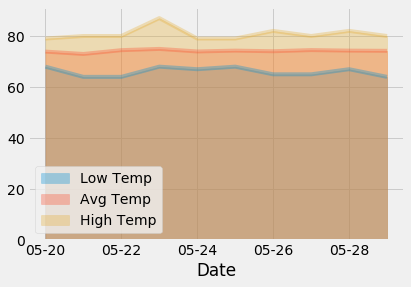

In [28]:
# Plot the daily normals as an area plot
normals_df.plot.area(stacked=False, alpha=.333)

# Save Figure

### Temperature Analysis I

In [29]:
hawaii_measurements = pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_stations = pd.read_csv('Resources/hawaii_stations.csv')
hawaii_measurements.head(2)

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63


In [30]:
hawaii_measurements.tail(2)

,station,date,prcp,tobs
19548,USC00516128,2017-08-22,0.50,76
19549,USC00516128,2017-08-23,0.45,76


In [31]:
#Finding average temperature by grouping by 
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

In [32]:
#Display output
avg_june_temp['tobs']

station
USC00511918    74.139394
USC00513117    74.050847
USC00514830    76.005376
USC00516128    71.937220
USC00517948    76.655405
USC00518838    73.394737
USC00519281    73.271186
USC00519397    77.559322
USC00519523    76.668103
Name: tobs, dtype: float64

In [33]:
#Display output
avg_dec_temp['tobs']

station
USC00511918    69.684211
USC00513117    71.069444
USC00514830    73.224719
USC00516128    69.291262
USC00517948    71.834862
USC00518838    72.421053
USC00519281    69.903226
USC00519397    71.109524
USC00519523    72.433333
Name: tobs, dtype: float64

In [34]:
# Calculate Independent (Two Sample) T-Test
import scipy.stats as stats
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)